<a href="https://colab.research.google.com/github/camaro1200/UNet/blob/main/Unet_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from numpy import random

from itertools import islice

import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.nn.functional import sigmoid
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import transforms
from scipy import ndimage

### Display Image

(512, 512, 3)
(512, 512)


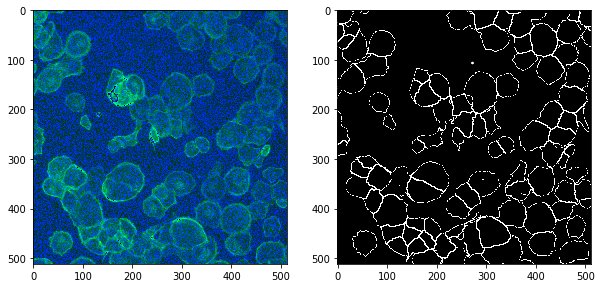

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('/home/iris/paulshab/UNet/data/BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('/home/iris/paulshab/UNet/data/BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

print(im.shape)
print(mask.shape)


### Data Augmentation

In [3]:
import albumentations as A
import cv2

class Augment:
    def __init__(self, transform=None):
        if transform is None:
            self.transform = A.Compose(
                [A.VerticalFlip(p=0.5),
                 #A.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5), 
                 #A.RandomCrop (height=200, width=200, always_apply=False, p=0.5)  
                ],
            additional_targets={'image0': 'image', 'image1': 'image'}
            )
          
    def create(self, img, mask, use_augs=True):
        img = img.numpy()
        mask = mask.numpy()

      #img = np.transpose(img, (2, 1, 0))
      #mask = np.transpose(mask, (2, 1, 0))

        if use_augs:
            tf= self.transform(image=img, image0=mask)
            img = tf["image"]
            mask = tf["image0"]

        img = torch.Tensor(img)
        mask = torch.Tensor(mask.copy())
        mask = (mask.float() > 0.5).float()

        #print("type", img.dtype, img.shape)
        return img, mask


### Save into Train and Test Set

In [4]:
import glob

def get_set(img_files):
    img_list = []
    for img in img_files:
        pic = skimage.img_as_ubyte(skimage.io.imread(img))
        pic = torch.from_numpy(pic)
        img_list.append(pic)
        
    img_list  = torch.stack(img_list, dim=0)
    return img_list

In [5]:
X_train_files = glob.glob('/home/iris/paulshab/UNet/data/BBBC018_v1_images-fixed/train/*.bmp')
X_train_labels = glob.glob('/home/iris/paulshab/UNet/data/BBBC018_v1_outlines/train/*.png')

X_test_files = glob.glob('/home/iris/paulshab/UNet/data/BBBC018_v1_images-fixed/val/*.bmp')
X_test_labels = glob.glob('/home/iris/paulshab/UNet/data/BBBC018_v1_outlines/val/*.png')

# X_train
X_train = get_set(X_train_files)
X_train = torch.transpose(X_train , 1, 3)
print("X_train:", X_train.shape, X_train.dtype)

# y_train
y_train = get_set(X_train_labels)
y_train = y_train[:, None, :, :]
print("y_train:", y_train.shape, y_train.dtype)

# X_train
X_test = get_set(X_test_files)
X_test = torch.transpose(X_test , 1, 3)
print("\nX_test:", X_test.shape, X_test.dtype)

# y_test
y_test = get_set(X_test_labels)
y_test = y_test[:, None, :, :]
print("y_test:", y_test.shape, y_test.dtype)


X_train: torch.Size([41, 3, 512, 512]) torch.uint8
y_train: torch.Size([41, 1, 512, 512]) torch.uint8

X_test: torch.Size([7, 3, 512, 512]) torch.uint8
y_test: torch.Size([7, 1, 512, 512]) torch.uint8


### Store Data in Dataset

In [6]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, imgs, labels, transform=None, use_augs=True):
        if transform is None:
            self.transform = transforms.Compose(
              [
               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
          ])
        else:
            self.transform = transform

        
        self.labels = labels
        self.imgs = imgs
        
        self.use_augs = use_augs
        #self.tr = TransformSegm()
        self.augment = Augment()

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.imgs)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = self.imgs[index]
        y = self.labels[index]

        #X, y = self.tr(X, y, self.use_augs)
        X, y = self.augment.create(X, y, self.use_augs)
        #print(X.dtype, X.shape)

        X = self.transform(X)

        return X, y

training_set = Dataset(X_train, y_train, use_augs=True)
testing_set = Dataset(X_test, y_test, use_augs=True)

In [ ]:
training_set[0][1]

[ x1, x2, x3 .. xn] --> train 
[ xt1, xt2, xt4.. ] --> test 

### Dataloaders

In [7]:
trainloader = DataLoader(
    training_set,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=True
)

testloader = DataLoader(
    testing_set,
    batch_size=2 ,
    shuffle=False,
    num_workers=1,
    drop_last=True
)

In [8]:
### check dataloader
for batch in islice(trainloader, 0, 1):
    images, labels = batch

    print(images.shape, labels.shape)
    #print(labels)

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


### U-Net Network

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.feat_map1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),            # ( in_channels, out_channels, window_size, )
            nn.ReLU(),              
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, stride = 2),                # kernel size, stride
        )

        self.feat_map2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),          # ( in_channels, out_channels, window_size, )
            nn.ReLU(),              
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, stride = 2),                # kernel size, stride
        )

        self.feat_map3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),         # ( in_channels, out_channels, window_size, )
            nn.ReLU(),              
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, stride = 2),                # kernel size, stride
        )

        self.feat_map4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),         # ( in_channels, out_channels, window_size, )
            nn.ReLU(),              
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, stride = 2),                # kernel size, stride
        )

        self.feat_map5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),        # ( in_channels, out_channels, window_size, )
            nn.ReLU(),              
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),

            # upsample 1

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.feat_map6 =  nn.Sequential( 
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),

            # upsample 2

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.feat_map7 =  nn.Sequential( 
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            # upsample 3

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.feat_map8 =  nn.Sequential( 
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            # upsample 4

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.final_map =  nn.Sequential( 
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            ## prediction to classes

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )


    def forward(self, X):
        #---------------encoder--------------------

        max_pool = nn.MaxPool2d(2, stride = 2)
      
        X = self.feat_map1(X)
        #self.cc1 = X[:, :, 90:418, 90:418]
        self.cc1 = X
        X = max_pool(X)

      
        X = self.feat_map2(X)
        #self.cc2 = X[:, :, 41:209, 41:209]
        self.cc2 = X
        X = max_pool(X)

        X = self.feat_map3(X)
        #self.cc3 = X[:, :, 16:104, 16:104]      #!!!!
        self.cc3 = X
        X = max_pool(X)

        X = self.feat_map4(X)
        #self.cc4 = X[:, :, 4:52, 4:52]
        self.cc4 = X
        X = max_pool(X)

        #---------------decoder--------------------

        X = self.feat_map5(X)
        X = torch.cat((X, self.cc4), 1)

        X = self.feat_map6(X)  
        X = torch.cat((X, self.cc3), 1)

        X = self.feat_map7(X)
        X = torch.cat((X, self.cc2), 1)

        X = self.feat_map8(X)
        X = torch.cat((X, self.cc1), 1)

        X = self.final_map(X)
      

        #print("cat1:", self.cc1.shape)
        #print("cat2:", self.cc2.shape)
        #print("cat3:", self.cc3.shape)
        #print("cat4:", self.cc4.shape)
        
        return X 

# Train Network


### Loss Function + Optimizer

In [10]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

### Sanity Check on 1 batch:

In [ ]:
from tqdm import trange
from time import sleep

net_batch = UNet().cuda()
net_batch.train()
learning_rate = 1e-5

optimizer2 = optim.Adam(net_batch.parameters(), lr=learning_rate)


scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[80,160,240],
    gamma=0.1
)

loss_vals = []

batch = next(iter(trainloader))
images, labels = batch
images, labels = images[:1].cuda(), labels[:1].cuda()
print("Shapes", images.shape, labels.shape)

#t = trange(200, desc='Bar desc', leave=True)

num_epochs = 50000
for epoch in tqdm(range(num_epochs)):
    y_pred = net_batch(images.float().requires_grad_(True))
    #print(y_pred.shape)
    
    loss = criterion(y_pred, labels.float())

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
    #t.set_description(f"Bar desc {loss.item()}")
    #t.refresh()

    loss_vals.append(loss.item())
    #scheduler.step()

#### Sanity Check Graph:

In [ ]:
loss_vals[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_vals) +1), loss_vals, color ='blue')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel("Number of iterations")
plt.ylabel("cost (J)")
plt.title("Convergence of gradient descent")

#### Prediction on Batch:

In [ ]:
plt.figure(figsize=(10,10))

net_batch.eval()
batch_img = images[0]
batch_img = batch_img[None,...]

with torch.no_grad():
    batch_pred = net_batch(batch_img)

ax1 = plt.subplot(131)

#print(sigmoid(batch_pred)[0][0][10])
batch_pred = (sigmoid(batch_pred) > 0.5).float()[0]
batch_pred = batch_pred.squeeze().cpu().numpy()
plt.imshow(batch_pred)

ax2 = plt.subplot(132)
check_img = labels
check_img = check_img[0].squeeze().cpu().numpy()
plt.imshow(check_img)

#l = (sigmoid(y_pred) > 0.05).float()[0]
#l = l.squeeze().cpu().numpy()
#plt.imshow(l)

In [ ]:
print("IOU", iou_np(batch_pred, check_img))
print("ACC", acc_numpy(batch_pred, check_img))

#### Full Model Train

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

net = UNet().to(device)
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)    # very stable

net.train()
num_epochs = 200

loss_arr = []
for epoch in tqdm(range(num_epochs)):
    loss_val = 0
    #with torch.no_grad():
    for batch in trainloader:
        images, labels = batch
    
        images, labels = images.to(device), labels.to(device)
        
        #print("images:", images.shape)
        #print("labels:", labels.shape)

        #print("images:", images)
        #print("labels:", labels)
        
        #forward
        y_pred = net(images.float())
        #print("forward success")
        #print("pred", y_pred)
        
        loss = criterion(y_pred, labels.float())
        loss_val = loss + loss_val
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #gradient decent
        optimizer.step()

        
    loss_val = loss_val/10
    loss_arr.append(loss_val)
  

  0%|          | 0/200 [00:00<?, ?it/s]/home/iris/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 200/200 [14:55<00:00,  4.48s/it]


tensor(0.1680, device='cuda:1', grad_fn=<DivBackward0>)


Text(0.5, 1.0, 'Convergence of gradient descent')

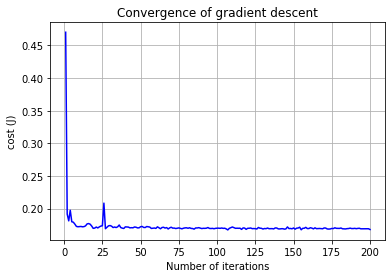

In [12]:
import matplotlib.pyplot as plt
print(loss_arr[-1])
plt.plot(range(1, len(loss_arr) +1), loss_arr, color ='blue')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel("Number of iterations")
plt.ylabel("cost (J)")
plt.title("Convergence of gradient descent")

In [ ]:
torch.cuda.empty_cache()

## Accuracy + IOU

In [13]:
def iou_np(mat1, mat2):
    intersection = np.logical_and(mat1, mat2)
    union = np.logical_or(mat1, mat2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def acc_numpy(mat1, mat2):
    cnt = (mat1==mat2)
    count = np.count_nonzero(cnt)
    return count /(512*512)

def sig(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
#cnt = acc_numpy(pred, check_img)
#iou_np(pred, check_img)

In [26]:
net.eval()

img, mask = training_set[0]

img = img[None,...].float().to(device)

with torch.no_grad():
    pred = net(img)

logits = sigmoid(pred)
print(logits)
pred = (sigmoid(pred) > 0.032).float()[0]
pred = pred.squeeze().cpu().numpy()
mask = mask.squeeze().numpy()

iou_np(pred, mask)


tensor([[[[0.0236, 0.0318, 0.0542,  ..., 0.0450, 0.0558, 0.1052],
          [0.1089, 0.0130, 0.0133,  ..., 0.0113, 0.0155, 0.0828],
          [0.0960, 0.0226, 0.0200,  ..., 0.0176, 0.0182, 0.0709],
          ...,
          [0.0338, 0.0143, 0.0165,  ..., 0.0052, 0.0079, 0.0247],
          [0.0577, 0.0223, 0.0186,  ..., 0.0032, 0.0049, 0.0100],
          [0.1624, 0.0599, 0.0589,  ..., 0.0124, 0.0093, 0.0156]]]],
       device='cuda:1')


0.04227649625678996

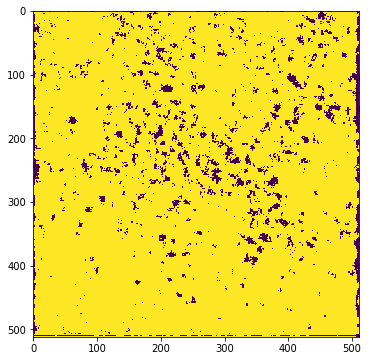

In [27]:
plt.imshow(pred)

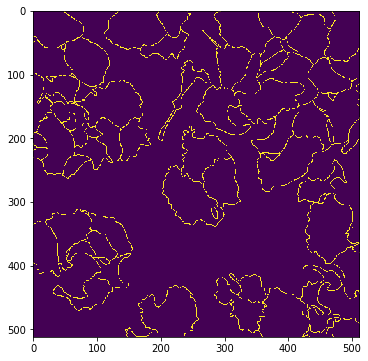

In [25]:
plt.imshow(mask)